# Business Problem: 

Learn a buy signal from an already existing trading rule.

The current trading has a problem. The rule has more loses than wins. This is because the trading rules is set by if-else-then logic and these logic are very rigid. To understand this better, image a piece of cheese. of course,we only want the meat. The holes are analogy for failed trades while the meat represents the successfull trades. In this situation, we want our cheese to have at least 2/3 meat with maximum 1/3 holes.

We aim to capture a subset of the trading rule, whose logic is not based on static if-then-else statements but wit hMachine Learning.

![NN](cheese.jpg)


This is the current strategy is like this cheese. Got more holes that meat. 



## Feature Engineering:
All information from Foreign-Exchange providers are the same - the OHLC.
 - O -  open price for the period
 - H -  high price for the period
 - L -   low price for the period
 - C - close price for the period

These are the basic buildling blocks of our Fields. Unfortunately, we can't use these in their raw form. we need to mix and combine them - on certain relevant ways - that can help our Machine Learning Algorithm to create a rule. The following concepts are high introductions that we will use to Feature Engineer our fields ( columns )  

### Period
Each row of data (OHLC) is time-bound by a period. Period could be M1, M5, M15, H1, H4, D1, W or M. We will use the following for our dataset. 
 - M15 or 15-minute
 - H1 or 1-Hour period
 - H4 or 4-Hour period

### Stochastic Oscillator Formula

> %K = 100(C - L14)/(H14 - L14)
>
> Where:
> - C = the most recent closing price
> - L14 = the low of the 14 previous trading sessions
> - H14 = the highest price traded during the same 14-day period
> - %K= the current market rate for the currency pair
> - %D = 3-period moving average of %K

Read more: Stochastic Oscillator https://www.investopedia.com/terms/s/stochasticoscillator.asp#ixzz5S0c7KDgw 

### Bollinger Band
> A Bollinger Band is a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average of the security's price. A Bollinger Band, developed by famous technical trader John Bollinger, is normally plotted two standard deviations away from a simple moving average but can be adjusted to user preferences.

Read more: Bollinger Band https://www.investopedia.com/terms/b/bollingerbands.asp#ixzz5S0efY97S 


### Fields / Columns
Our field will be Stochastic Osccillator detect momentum strength and Bollinger Band to detect direction at m15, h1 and h4. The idea is to capture the direction and strength of movement using these 2 indicators.

### Other Trading-related matters

This data is for EURUSD, which means the data is sensitive to European Euro and American Dollar. From trading class, EURUSD is sensitive to 3 news events: US NFP (Non-Farm Payroll) Report and ECB (European Central Bank) Interest Rate Decision and FOMC (Federal Open Market Committee) Interest Rate Decision. These 3 events are scheduled through-out the year with different intervals. ( NFP are release every 1st friday of the month while FOMC and ECB Interest Rate adjustment happens 8 times in a year). 

We include the Week number to factor in this information. We expect Week number to factor in the change in direction for mid-term to long term. Month / Day and Hour are to factor in the changes in the short - mid term. 

### Want column
This column is where some trading-related concepts is applied. A trade that is profitable with the proper Risk and Reward Ratio is the type of trades we want.  

![want](want_sample.jpg)

Sample of trades that are "True" 

## Exploratory Data Analysis

In [13]:
import pandas as pd                           # load pandas, numpy, seaborn and matplotlib for this project.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DataScience = pd.read_csv('DataScience.csv')   # Read the data from the file.
DataScience.head()                             # see the headers of the data

,week,month,day,hour,stoch_m15,stoch_h1,stoch_h4,bband_m15,bband_h1,bband_h4,want
0,1,1,1,0,66.67,100.00,100.00,65.21,82.41,159.61,False
1,1,1,1,0,81.48,100.00,100.00,49.24,82.41,159.61,False
2,1,1,1,8,60.00,91.11,97.90,32.81,66.94,118.31,False
3,1,1,1,14,46.43,83.33,97.17,47.32,64.21,103.40,False
4,1,1,1,15,50.00,70.45,97.17,46.79,58.92,103.40,False


From the original inputs of OHLC (Open - Low - High - Close), we already "feature engineered" certain fields that we want. It may __not be enough__ but we will use these features for now. 

In [14]:
DataScience.shape

(435213, 11)

In [15]:
DataScience.columns.isnull().sum()                 # locate null points in all columns. None Seen.

0

In [16]:
DataScience.info()
# below is how the columns are suppose to be.
#week       // week number                            1 to 53
#month      // month number                           1 to 12
#hour       // hour of day                            0 to 23
#day        // day of the week                        0 to 5 - Monday to Friday.
#stoch_m15  // stochastic value at the m15 - 5,3,3    0 - 100
#stoch_h1   // stochastic value at the h1 - 5,3,3     0 - 100
#stoch_h4   // stochastic value at the h4 - 5,3,3     0 - 100
#bband_m15  // m15 bollinger band (20,0,2) value      0 - 150%?
#bband_h1   // h1  bollinger band (20,0,2) value      0 - 150%?
#bband_h4   // h4  bollinger band (20,0,2) value      0 - 150%?
#want       // target field for ML                    True / False

# Expected dytpes are correctly loaded.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435213 entries, 0 to 435212
Data columns (total 11 columns):
week         435213 non-null int64
month        435213 non-null int64
day          435213 non-null int64
hour         435213 non-null int64
stoch_m15    435213 non-null float64
stoch_h1     435213 non-null float64
stoch_h4     435213 non-null float64
bband_m15    435213 non-null float64
bband_h1     435213 non-null float64
bband_h4     435213 non-null float64
want         435213 non-null bool
dtypes: bool(1), float64(6), int64(4)
memory usage: 33.6 MB


In [17]:
DataScience.describe(include='all')             # let's check out our columns

,week,month,day,hour,stoch_m15,stoch_h1,stoch_h4,bband_m15,bband_h1,bband_h4,want
count,435213.00000,435213.000000,435213.000000,435213.000000,435213.000000,435213.000000,435213.000000,435213.000000,435213.000000,435213.000000,435213
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,391207
mean,26.48422,6.466195,2.990605,11.453674,50.234412,50.378678,50.790941,55.705812,57.714467,57.422285,NaN
std,14.94437,3.424949,1.410580,6.893196,33.392176,33.857653,35.178644,36.885891,37.377573,35.085463,NaN
min,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,13.00000,3.000000,2.000000,5.000000,18.750000,18.000000,16.020000,26.540000,28.940000,29.460000,NaN
50%,26.00000,6.000000,3.000000,11.000000,50.000000,50.480000,51.820000,50.850000,52.770000,54.760000,NaN
75%,39.00000,9.000000,4.000000,17.000000,81.820000,82.720000,85.460000,78.700000,80.480000,81.100000,NaN


We very well konw there are only 52 weeks in a year. Epcoh week number however, got 53 on certains years. Research will show year 2015 as an exmaple with week 53. The data is correct. 

 Note to the Business Question: Singapore is @ +8GMT while the Broker where this information came from is @ +5GMT.

  Broker closes at Friday 2359 (+5GMT) which is Singapore Sat 0259 (+8GMT)

 Broker Opens at Monday 0001 (+5GMT) which is Singapore Monday 0300 (+8 GMT)

 These opening and closing information confirms that day should only be 1 - 5, which is correct.

In [18]:
mask = DataScience.duplicated(keep=False)          # create a mask for duplicated items
print (DataScience[mask])                          # apply the mask over the Data Set and display it.
DataScience[mask].shape                            # see the shape of the duplicated rows / samples

        week  month  day  hour  stoch_m15  stoch_h1  stoch_h4  bband_m15  \
4114       9      3    4    23      87.50     47.76    100.00       8.02   
4115       9      3    4    23      87.50     47.76    100.00       8.02   
8678      19      5    2    14       0.00     46.00      0.00      55.07   
8679      19      5    2    14       0.00     46.00      0.00      55.07   
11228     24      6    4     4     100.00     48.28     51.69      48.04   
11229     24      6    4     4     100.00     48.28     51.69      48.04   
11230     24      6    4     5     100.00     51.61     51.69      58.59   
11231     24      6    4     5     100.00     51.61     51.69      58.59   
13920     30      7    2     6       0.00     75.00     60.38      24.79   
13921     30      7    2     6       0.00     75.00     60.38      24.79   
14101     30      7    4     3     100.00     18.18    100.00       6.39   
14102     30      7    4     3     100.00     18.18    100.00       6.39   
17384     37

(104, 11)

In [19]:
DataScience.drop_duplicates(inplace=True)           # 52 entries were duplicate. they were dropped.
DataScience.shape                                   # final size is now 52 rows smaller.

(435161, 11)

We plot all the fields in a historgram so get a feel of what type of distribution the data has..

<Figure size 432x288 with 0 Axes>

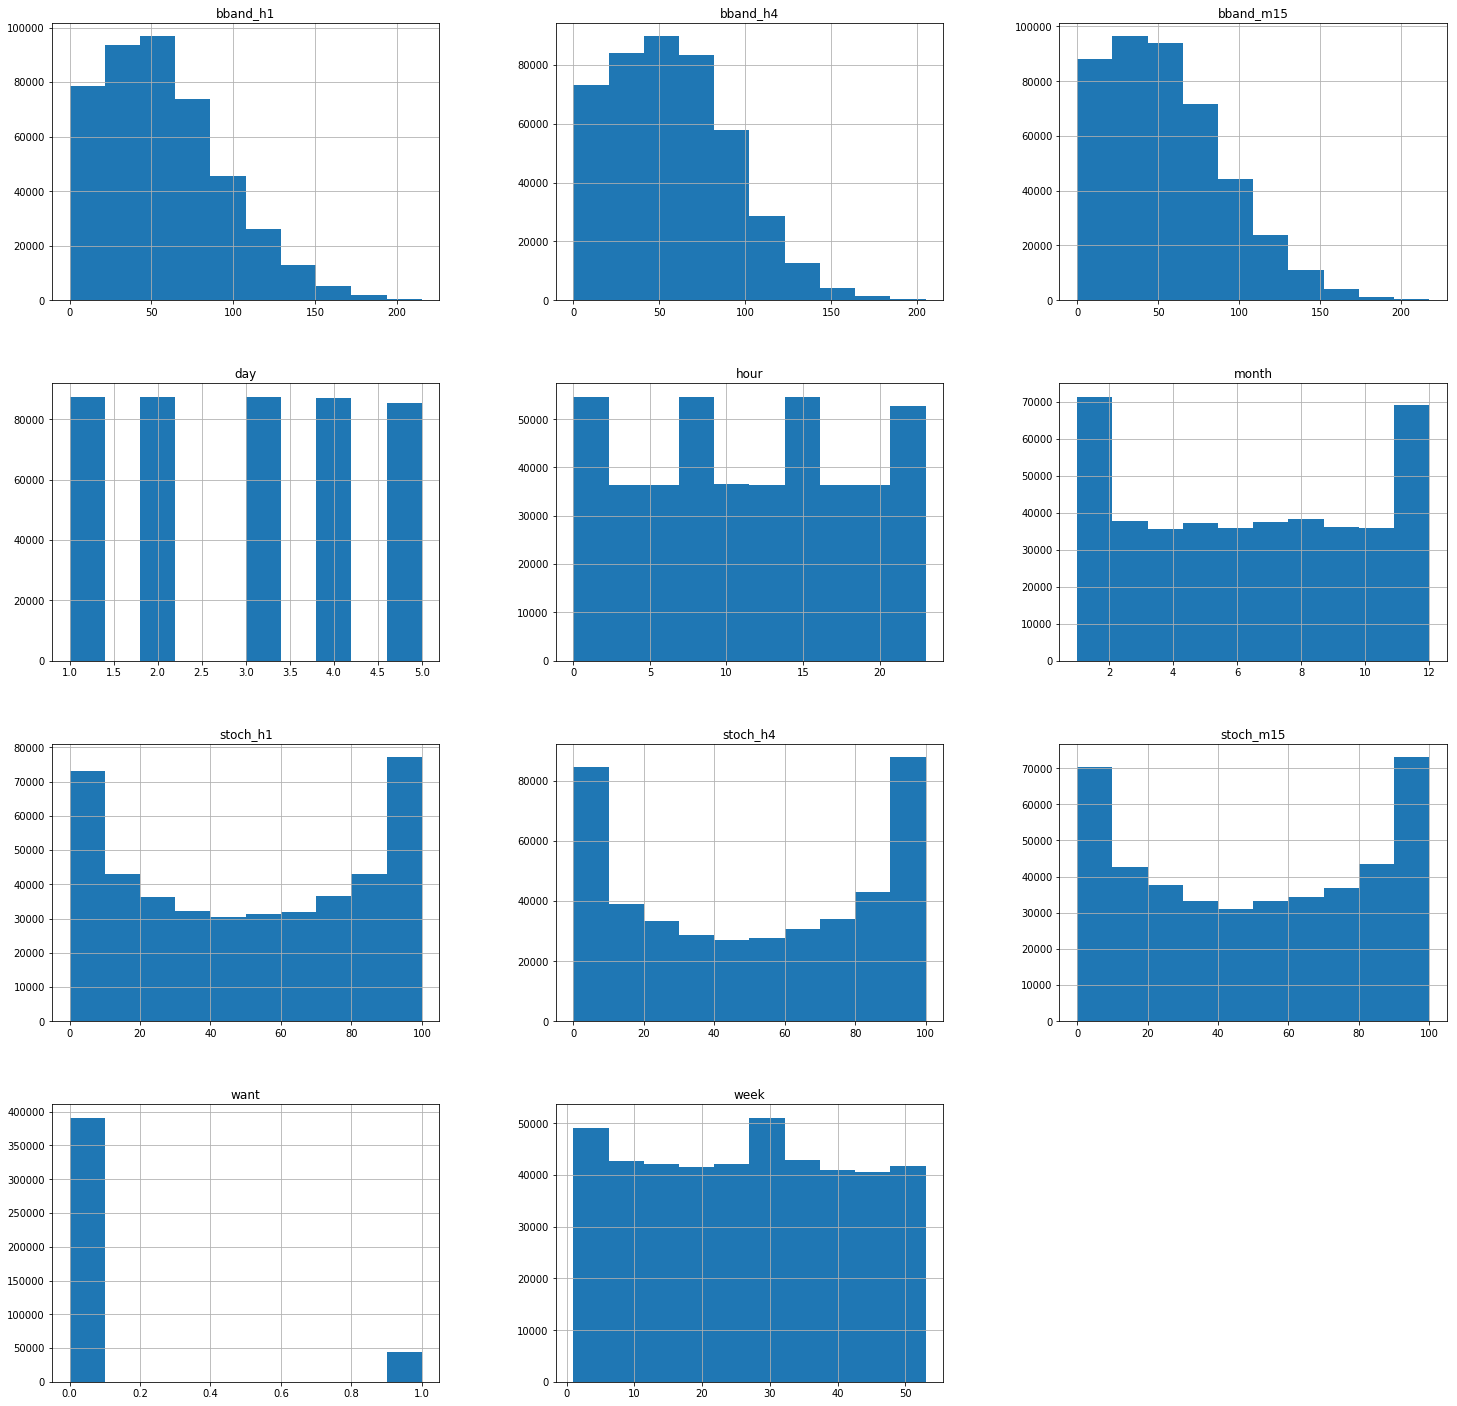

<Figure size 432x288 with 0 Axes>

In [20]:
DataScience.hist(figsize=(25, 25))
plt.figure()

We can see that stoch_m15 has values mostly on the extreme ends (0 and 100). Chart is flashy but it doesn't tell us much.

Let's check our Target columns using describe. stoch_xx fields are as expected. 
We know for a fact that stoch_xx is a percentage value from 0-100. we can confirm from Min, Mean, 50%, Max that the scale is indeed from 0 - 100%.

In [21]:
DataScience.stoch_m15.describe()                         # let's check our target column

count    435161.000000
mean         50.234094
std          33.390028
min           0.000000
25%          18.750000
50%          50.000000
75%          81.820000
max         100.000000
Name: stoch_m15, dtype: float64

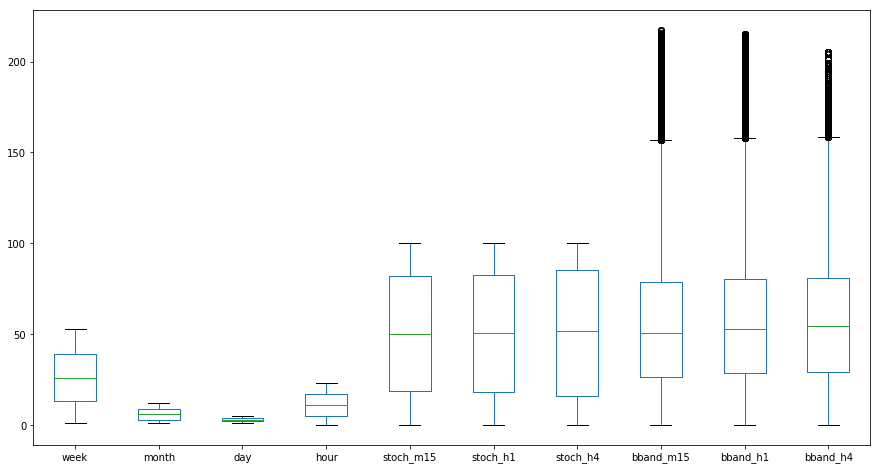

In [22]:
DataScience.drop('want', axis=1).plot(kind='box', figsize=(15, 8))  # We plot the feature columns

All values range from 0 - 217. Those outliers are important on it's current setate. bband_m15 at 200+ means price is way, way, way outside the bband area of 2 sigma. These 'overstreching' is important for our target column.

## Data Munging



In [23]:
DataScience.want.unique()

array([False,  True])

Problem #1: Our target column is in 'True' and 'False' mode. we need to change those to 0s and 1s.

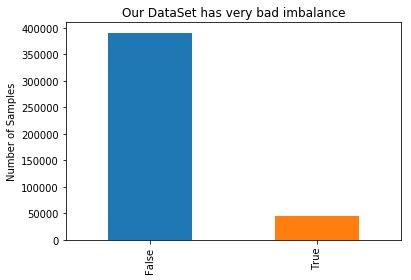

In [24]:
DataScience.want.value_counts().plot.bar()          #visuzlize the imbalance
plt.ylabel('Number of Samples')
plt.title('Our DataSet has very bad imbalance')
plt.show()

In [25]:
print (DataScience.want.value_counts() ,'\n')

count_of_False = 0
count_of_True  = 0

for i in DataScience.want:
    if i == 0:
        count_of_False += 1
    else:
        count_of_True += 1

print( "False: " + str(count_of_False/(count_of_False+count_of_True)*100) + "   percent \n" + 
       "True : " + str(count_of_True/(count_of_False+count_of_True)*100), ' percent')

False    391161
True      44000
Name: want, dtype: int64 

False: 89.8887997775536   percent 
True : 10.111200222446405  percent


Problem #2: Our target is also heaviy imbalanced. we need to correct this imbalance.

In [26]:
# change the want column to 0's and 1's

#split the want to 'true' and 'false'. save series in want_n
want_n = pd.get_dummies(DataScience.want)
#print (want_n)

# concat want_n to the dataset
DataScience = pd.concat([DataScience,want_n], axis =1 )

In [27]:
DataScience.merge(want_n,left_index=True, right_index=True)
DataScience.head(3)

,week,month,day,hour,stoch_m15,stoch_h1,stoch_h4,bband_m15,bband_h1,bband_h4,want,False,True
0,1,1,1,0,66.67,100.00,100.0,65.21,82.41,159.61,False,1,0
1,1,1,1,0,81.48,100.00,100.0,49.24,82.41,159.61,False,1,0
2,1,1,1,8,60.00,91.11,97.9,32.81,66.94,118.31,False,1,0


In [28]:
DataScience.drop(columns=['want'], inplace = True)
DataScience.drop(columns=[False], inplace = True)

DataScience.columns.view()

Index([     'week',     'month',       'day',      'hour', 'stoch_m15',
        'stoch_h1',  'stoch_h4', 'bband_m15',  'bband_h1',  'bband_h4',
              True],
      dtype='object')

In [29]:
DataScience.rename(columns={True: 'want'}, inplace=True)
DataScience.columns.view()

Index(['week', 'month', 'day', 'hour', 'stoch_m15', 'stoch_h1', 'stoch_h4',
       'bband_m15', 'bband_h1', 'bband_h4', 'want'],
      dtype='object')

In [30]:
DataScience.head(3)

,week,month,day,hour,stoch_m15,stoch_h1,stoch_h4,bband_m15,bband_h1,bband_h4,want
0,1,1,1,0,66.67,100.00,100.0,65.21,82.41,159.61,0
1,1,1,1,0,81.48,100.00,100.0,49.24,82.41,159.61,0
2,1,1,1,8,60.00,91.11,97.9,32.81,66.94,118.31,0


Problem #1 fixed! Target field are 0s and 1s!

we will use SMOTE to increase the number of 1's in our target field.

In [31]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE + Tomek links
sm = SMOTE()

X = DataScience.drop(columns='want', axis =1)
y = DataScience.want

print ( 'before SMOTE: ')
print ( 'size of X = ',X.shape, '\n' )
print ( 'show the contents of X\n', X.head(5) ,'\n\n')

print ( 'size of y = ',y.shape, '\n' )
print ( 'show the contents of y\n', y.head(5) )

#X_resampled, y_resampled = sm.fit_sample(X, y)

before SMOTE: 
size of X =  (435161, 10) 

show the contents of X
    week  month  day  hour  stoch_m15  stoch_h1  stoch_h4  bband_m15  bband_h1  \
0     1      1    1     0      66.67    100.00    100.00      65.21     82.41   
1     1      1    1     0      81.48    100.00    100.00      49.24     82.41   
2     1      1    1     8      60.00     91.11     97.90      32.81     66.94   
3     1      1    1    14      46.43     83.33     97.17      47.32     64.21   
4     1      1    1    15      50.00     70.45     97.17      46.79     58.92   

   bband_h4  
0    159.61  
1    159.61  
2    118.31  
3    103.40  
4    103.40   


size of y =  (435161,) 

show the contents of y
 0    0
1    0
2    0
3    0
4    0
Name: want, dtype: uint8


In [32]:
X_resampled, y_resampled = sm.fit_sample(X, y)                # fit the smote

In [33]:
print ( 'after SMOTE: ')
print ( 'size of X_resampled = ',X_resampled.shape, '\n' )
columns = ['week','month','day','hour','stoch_m15','stoch_h1','stoch_h4','bband_m15','bband_h1','bband_h4']
df = pd.DataFrame(X_resampled,columns=columns)
X_smt_back_df = df
print ( 'show the contents of X_smt_back_df : \n', X_smt_back_df.head(5) ,'\n\n')
print ( 'show the contents of X_smt_back_df = ', X_smt_back_df.shape)

after SMOTE: 
size of X_resampled =  (782322, 10) 

show the contents of X_smt_back_df : 
    week  month  day  hour  stoch_m15  stoch_h1  stoch_h4  bband_m15  bband_h1  \
0   1.0    1.0  1.0   0.0      66.67    100.00    100.00      65.21     82.41   
1   1.0    1.0  1.0   0.0      81.48    100.00    100.00      49.24     82.41   
2   1.0    1.0  1.0   8.0      60.00     91.11     97.90      32.81     66.94   
3   1.0    1.0  1.0  14.0      46.43     83.33     97.17      47.32     64.21   
4   1.0    1.0  1.0  15.0      50.00     70.45     97.17      46.79     58.92   

   bband_h4  
0    159.61  
1    159.61  
2    118.31  
3    103.40  
4    103.40   


show the contents of X_smt_back_df =  (782322, 10)


In [34]:
count0=0
count1=0

for i in y_resampled:
    if i == 0:
        count0 += 1
    else:
        count1 += 1

print("0: " + str(count0) + "\n" + "1: " + str(count1),'\n')

print ( 'size of y_resampled = ',y_resampled.shape )

0: 391161
1: 391161 

size of y_resampled =  (782322,)


Problem #2 fixed! data is not imbalance anymore

## Make the Models

In [35]:
#split the data into train / test first. 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smt_back_df ,y_resampled, random_state=111)

In [36]:
%%time

from sklearn.ensemble import RandomForestClassifier     # define the models to use
RF_instance = RandomForestClassifier()                  # declare the instance
RF = RF_instance.fit(X_train,y_train)                   # Fit the models.
y_pred_RF = RF.predict(X_test)                          # predict the y
proba_RF =   RF.predict_proba(X_test)                   # compute the probabilies..
proba_RF = proba_RF[:,1]
print ('y_pred_RF shape :' , y_pred_RF.shape)           #resulting y_pred_RF is a 1D numpy arrays of 0s and 1s. 
print ('y_pred_RF contents : ', y_pred_RF)
print (' proba_RF contents : ', proba_RF)
print ('\n' )

from sklearn.linear_model import LogisticRegressionCV   # USE Logistic Regeression here..
LR_instance = LogisticRegressionCV()                    # declare the instance
LR = LR_instance.fit(X_train,y_train)                   # Fit the models.
y_pred_LR = LR.predict(X_test)                          # predict the y
proba_LR =   LR.predict_proba(X_test)                   # compute the probabilies..
proba_LR = proba_LR[:,1]
print ('y_pred_LR shape :' , y_pred_LR.shape)           #resulting y_pred_LR is a 1D numpy arrays of 0s and 1s.
print ('y_pred_LR contents : ', y_pred_LR)
print ('  proba_LR contents : ', proba_LR)
print ('\n' )

from xgboost import XGBRegressor                        # USE XGBoost here..
XGBoost_instance = XGBRegressor()                       # declare the instance
XGB = XGBoost_instance.fit(X_train,y_train)             # Fit the models.
proba_XGB = XGB.predict(X_test)                         # predict the y
                                                        # computing the preds..
y_pred_XGB = []                                             # convert the probability to a 1D numpy arrays of 0s and 1s for scoring
mid = (max(proba_XGB) - min(proba_XGB))/2
for i in proba_XGB:                                         # createing a list
    if i < mid:
        y_pred_XGB.append(0)
    if i > mid:
        y_pred_XGB.append(1)        
y_pred_XGB = np.array(y_pred_XGB)                           # converign the list to a numppy array

print ('y_pred_XGB shape :' , y_pred_XGB.shape)         #resulting proba_XGB is a 1D numpy arrays probabilites.
print ('y_pred_XGB contents : ', y_pred_XGB)
print ('proba_XGB contents : ', proba_XGB)              #resulting proba_XGB is a 1D numpy arrays probabilites.
print ('\n' )

from sklearn.linear_model import SGDClassifier          # USE SGDClassifier here..
SGD_instance = SGDClassifier(loss = 'log', max_iter=1000)  # declare the instance
SGD = SGD_instance.fit(X_train,y_train)                 # Fit the models.
y_pred_SGD = SGD.predict(X_test)                        # predict the y
proba_SGD = SGD.predict_proba(X_test)                   # compute the probabilies..
proba_SGD = proba_SGD[:,1]
print ('y_pred_SGD shape :' , y_pred_SGD.shape)
print ('y_pred_SGD contents : ', y_pred_SGD)
print (' proba_SGD contents : ', proba_SGD)

y_pred_RF shape : (195581,)
y_pred_RF contents :  [0 0 1 ... 0 0 0]
 proba_RF contents :  [0.3 0.4 1.  ... 0.4 0.  0.1]


y_pred_LR shape : (195581,)
y_pred_LR contents :  [0 0 0 ... 1 0 0]
  proba_LR contents :  [0.44279688 0.28862343 0.42988191 ... 0.55499395 0.4186979  0.35250532]


y_pred_XGB shape : (195581,)
y_pred_XGB contents :  [0 0 1 ... 0 0 0]
proba_XGB contents :  [0.34245414 0.10179371 0.9410974  ... 0.41777828 0.19637978 0.20744258]


y_pred_SGD shape : (195581,)
y_pred_SGD contents :  [0 0 0 ... 0 0 0]
 proba_SGD contents :  [0.37617861 0.1390524  0.33913068 ... 0.49234184 0.34436706 0.21676439]
Wall time: 4min 24s


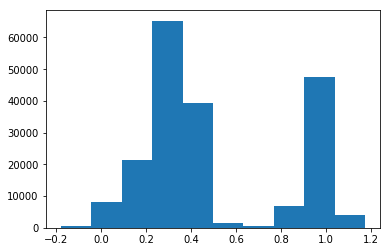

In [37]:
import matplotlib.pyplot as plt
plt.hist(proba_XGB)                                     # let's see those probabilities in action..
plt.show()

intermn chart showing the histogram for probab_XGB. This give us an idea of what comes out of the XBG predict.

### Score the different models..

In [38]:
%%time
from sklearn import metrics

print ('Random Forest Scores : ' )
print ('score for training set = %0.2f '%  RF.score(X_train, y_train) )  # check accuracy score..
print ('score for test set     = %0.2f '%  RF.score(X_test,  y_test) )   # make sure there is no overfitting
print ('\nConfusion Matrix' )
print (metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_RF) )      # confusion matrix
print ('\nClassification Report' )
print (metrics.classification_report(y_test, y_pred_RF))                # classification report for RF
print ('-------------------------------------------------------')
print ('\n' )

print ('Linear Regression Scores : ' )
print ('score for training set = %0.2f '%  LR.score(X_train, y_train) )  # check accuracy score..
print ('score for test set     = %0.2f '%  LR.score(X_test,  y_test) )   # make sure there is no overfitting
print ('\nConfusion Matrix' )
print (metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_LR) )      # confusion matrix
print ('\nClassification Report' )
print (metrics.classification_report(y_test, y_pred_LR))                # classification report for LR
print ('-------------------------------------------------------')
print ('\n' )

print ('eXtreme Gradient Boosting Scores : ' )
print ('score for training set = %0.2f '% XGB.score(X_train, y_train) )  # check accuracy score..
print ('score for test set     = %0.2f '% XGB.score(X_test,  y_test) )   # make sure there is no overfitting
print ('\nConfusion Matrix' )
print (metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_XGB) )     # confusion matrix
print ('\nClassification Report' )
print (metrics.classification_report(y_test, y_pred_XGB))               # classification report for XGB
print ('-------------------------------------------------------')
print ('\n' )                                     

print ('Stochastic Gradient Descend Scores : ' )
print ('score for training set = %0.2f '% SGD.score(X_train, y_train) )  # check accuracy score..
print ('score for test set     = %0.2f '% SGD.score(X_test,  y_test) )   # make sure there is no overfitting
print ('\nConfusion Matrix' )
print (metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_SGD) )     # confusion matrix
print ('\nClassification Report' )
print (metrics.classification_report(y_test, y_pred_SGD))               # classification report for SGD
print ('-------------------------------------------------------')

Random Forest Scores : 
score for training set = 1.00 
score for test set     = 0.95 

Confusion Matrix
[[96445  1600]
 [ 8027 89509]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.98      0.95     98045
          1       0.98      0.92      0.95     97536

avg / total       0.95      0.95      0.95    195581

-------------------------------------------------------


Linear Regression Scores : 
score for training set = 0.59 
score for test set     = 0.59 

Confusion Matrix
[[54298 43747]
 [37215 60321]]

Classification Report
             precision    recall  f1-score   support

          0       0.59      0.55      0.57     98045
          1       0.58      0.62      0.60     97536

avg / total       0.59      0.59      0.59    195581

-------------------------------------------------------


eXtreme Gradient Boosting Scores : 
score for training set = 0.49 
score for test set     = 0.50 

Confusion Matrix
[[98045     0]
 [3

For our business application, it is ok to miss a valid trade. we call this wasted opportunity but missing the boat do not make us lose money. This means our application is resilient to high False Negatives ( actual = yes, predicted = no ). Our metric for this is __Precision__. 

What we want is that when a trade is entered, it becomes a profit. We want a decent percentage of the ratio for True Postive / False Postive. High ration of ( actual = yes, predicted = yes / actual = no, predicted = yes )  

we can see from the confusion matrix that Random Forest and XGBoost give us a high True Postive / False Postive Ratio. 
Based on Confusion Matrix, our winner models are RandomForrest and XGBoost.

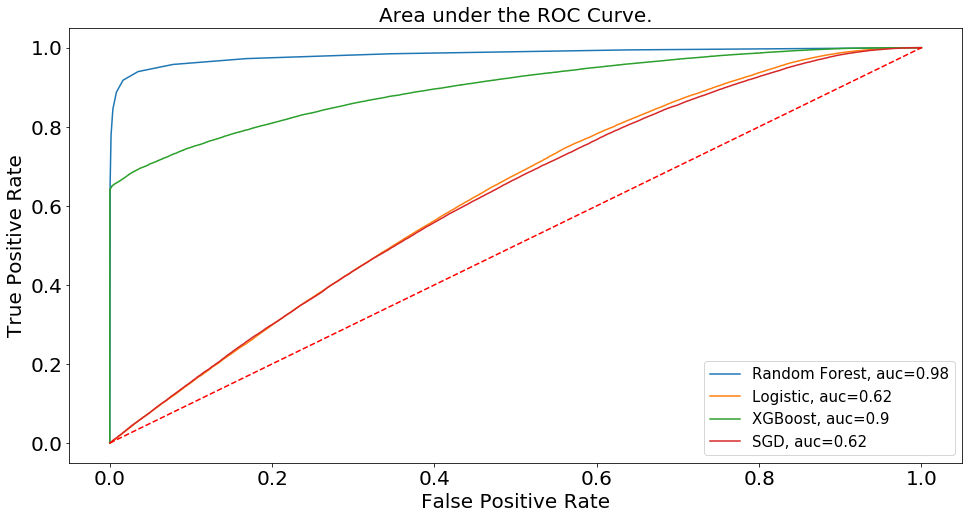

In [39]:
# calculate the fpr and tpr for all thresholds of the classification
# multiple ROC / AUC on one graph....
from sklearn import metrics

plt.figure(figsize=(16,8)).clf()

# define "lables" for use later in the auc curve drawing..
label = y_test

#plot random forest
fpr, tpr, thresh = metrics.roc_curve(label, proba_RF)
auc = round(metrics.roc_auc_score(label, proba_RF),2)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))

#plot logistic
fpr, tpr, thresh = metrics.roc_curve(label, proba_LR)
auc = round(metrics.roc_auc_score(label, proba_LR),2)
plt.plot(fpr,tpr,label="Logistic, auc="+str(auc))

#plot XG Boost
fpr, tpr, thresh = metrics.roc_curve(label, proba_XGB)
auc = round(metrics.roc_auc_score(label, proba_XGB),2)
plt.plot(fpr,tpr,label="XGBoost, auc="+str(auc))

#plot SGD
fpr, tpr, thresh = metrics.roc_curve(label, proba_SGD)
auc = round(metrics.roc_auc_score(label, proba_SGD),2)
plt.plot(fpr,tpr,label="SGD, auc="+str(auc))

#plot the ROC Curve
plt.plot([0,1],[0,1],'r--')
plt.tick_params(axis='both', labelsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize= 20)
plt.title('Area under the ROC Curve.',fontsize=20)
plt.legend(loc=0,fontsize=15)
None

### and the winner is...

we can see that the Logistic Regressino and it's cousin, Stochastic Gradient Descend ( SGD ) both perform poorly in AUC score too.

AUC confirms that winner models are __RandomForrest and XGBoost__

In [40]:
import pickle                                         # save the models to a file
with open(r"Final XGB.pickle", "wb") as output_file:
    pickle.dump(XGB,output_file)

with open(r"Final RF.pickle", "wb") as output_file:
    pickle.dump(RF,output_file)

after the models are 'pickled' and saved as files, it is worth noting that RandomForest is 61MB in size while XGB is only 69KB is size.

## Next Action:

> 1. test the model in real live data - DONE ( using a diff notebook )
> 2. try more models and build an ensemble of models as the final one.
> 3. improve current results thru StratifiedCVKfold and train/validation/test modes. - Done delow..
> 5. feature engineer some more then build more models !
>    - remove the date and times ( only with the bband and stoch values only )
>    - collapse the weeks column into 3 bins ( the 3 major news reports ) 
> 6. visualize the Random Forest

In [41]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.1.


### Next Action #3 - Cross validation to optimize hyperparameters of the chosen classifier

Cross validation is a technique for model selection/evaluation. cross_val_predict is very specific function (which gives you predictions of many models, trained during cross validation procedure). This method is to help choose the classifier, hyperparamters etc.

In our example, we have choosen RandomForest as the classifier

In [42]:
%%time
len(RF.estimators_)                 # there are 10 trees in my Random Forest. too less...

Wall time: 0 ns


10

so let's try out with 100 trees and see if the scores and AUC will change...

In [43]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier     # define the models to use
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

skf = StratifiedKFold(n_splits=5)                       # split can be 3, 5 or 10
classifier = RandomForestClassifier(n_estimators=100)   # define the classifier for use

# score the cross validation made.
score = cross_validate(classifier, X_smt_back_df, y_resampled, cv=skf, return_train_score=True )
print ( 'Random Forest Scores with 100 trees : ' )
print ( 'For the cross validation model:' )
print ( '      Train score : ' , score['train_score'] )
print ( '       Test score : ' , score['test_score'] )
print ( '         Fit time : ' , score['fit_time'] )
print ( '       Score Time : ' , score['score_time'] )

Random Forest Scores with 100 trees : 
For the cross validation model:
      Train score :  [1.         0.9999968  0.9999968  0.99999201 0.9999984 ]
       Test score :  [0.83795841 0.97676782 0.97538092 0.97455645 0.97517001]
         Fit time :  [348.05409932 332.21656871 332.78913903 339.25132513 354.73952127]
       Score Time :  [4.04676437 4.030756   4.07884717 4.35963988 4.3074584 ]
Wall time: 30min 16s


Is 100 trees better than 10 trees? looks like the answer is yes!

y_pred_RF shape : (195581,)
y_pred_RF contents :  [0 0 1 ... 0 0 0]
 proba_RF contents :  [0.2  0.21 1.   ... 0.48 0.02 0.12]




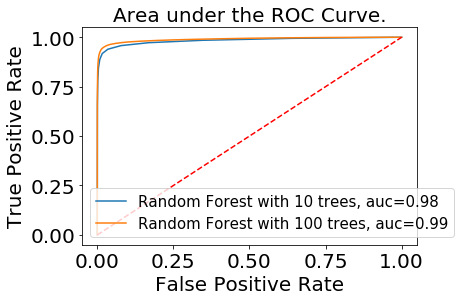

In [44]:
# is the score better with more trees? #fit the new RF with 100 trees!

from sklearn.ensemble import RandomForestClassifier         # define the models to use
RF_instance_100 = RandomForestClassifier(n_estimators=100)  # declare the instance, this time with 100 trees
RF_100 = RF_instance_100.fit(X_train,y_train)               # Fit the models.
y_pred_RF_100 = RF_100.predict(X_test)                      # predict the y
proba_RF_100 =  RF_100.predict_proba(X_test)                # compute the probabilies..
proba_RF_100 = proba_RF_100[:,1]
print ('y_pred_RF shape :' , y_pred_RF_100.shape)           #resulting y_pred_RF is a 1D numpy arrays of 0s and 1s. 
print ('y_pred_RF contents : ', y_pred_RF_100)
print (' proba_RF contents : ', proba_RF_100)
print ('\n' )

#plot random forest
fpr, tpr, thresh = metrics.roc_curve(label, proba_RF)
auc = round(metrics.roc_auc_score(label, proba_RF),2)
plt.plot(fpr,tpr,label="Random Forest with 10 trees, auc="+str(auc))

#plot random forest
fpr, tpr, thresh = metrics.roc_curve(label, proba_RF_100)
auc = round(metrics.roc_auc_score(label, proba_RF_100),2)
plt.plot(fpr,tpr,label="Random Forest with 100 trees, auc="+str(auc))

#plot the ROC Curve
plt.plot([0,1],[0,1],'r--')
plt.tick_params(axis='both', labelsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize= 20)
plt.title('Area under the ROC Curve.',fontsize=20)
plt.legend(loc=0,fontsize=15)
None

AUC confirms that 100 trees are better than 10. Save the 100 tree Forest 

In [45]:
import pickle                                               # save the models to a file

with open(r"Final RF 100.pickle", "wb") as output_file:
    pickle.dump(RF_100,output_file)

In [46]:
RF_100.feature_importances_                                 # check which features are most usefull.

array([0.0619534 , 0.06928005, 0.28798062, 0.11962828, 0.08421046,
       0.07004595, 0.07274114, 0.09118209, 0.07023465, 0.07274337])

In [47]:
feature_importance = pd.DataFrame(RF_100.feature_importances_)
feature_importance.rename({0:'week',1:'month',2:'day',3:'hour',4:'stoch_m15',5:'stoch_h1',6:'stoch_h4',7:'bband_m15',8:'bband_h1',9:'bband_h4'}, axis='index')

,0
week,0.061953
month,0.069280
day,0.287981
hour,0.119628
stoch_m15,0.084210
stoch_h1,0.070046
stoch_h4,0.072741
bband_m15,0.091182
bband_h1,0.070235
bband_h4,0.072743


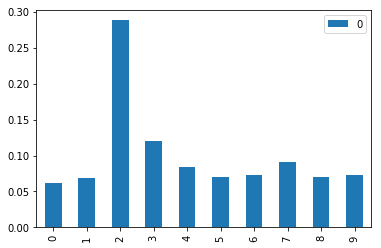

In [48]:
feature_importance.plot.bar()                               # add the RF feature importance on this dataframe then plot!!

### Next Action #5  - Visualize 1 tree from the Forest. 

In this example, Tree # 5

In [67]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from export_graphviz import Source
from IPython.display import display

graph = Source(tree.export_graphviz(RF_100, out_file=None
   , feature_names=label, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

ModuleNotFoundError: No module named 'export_graphviz'

In [52]:
feature_names = X_smt_back_df.columns
estimator = RF.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [61]:
!dot -Tpng tree.dot -o tree.png

'dot' is not recognized as an internal or external command,
operable program or batch file.


In [54]:
dot -Tpng tree.dot -o tree.png

SyntaxError: invalid syntax (<ipython-input-54-70e48a2729eb>, line 1)

In [53]:
# another way of drawing the tree.

from fastai.structured import draw_tree
draw_tree(RF.estimators_[5], X_smt_back_df, precision=3)

ModuleNotFoundError: No module named 'fastai'

In [56]:
!pip install pydot

  Running setup.py bdist_wheel for pydot: started
  Running setup.py bdist_wheel for pydot: finished with status 'done'
  Stored in directory: C:\Users\jonglim\AppData\Local\pip\Cache\wheels\6a\a5\14\25541ebcdeaf97a37b6d05c7ff15f5bd20f5e91b99d313e5b4
Successfully built pydot


In [60]:
import io
from scipy import misc
import pydot

def show_tree(decisionTree, file_path):
    dotfile = io.StringIO()
    export_graphviz(decisionTree, out_file=dotfile)
    pydot.graph_from_dot_data(dotfile.getvalue()).write_png(file_path)
    i = misc.imread(file_path)
    plt.imshow(i)

# To use it
show_tree(RF.estimators_[5], 'test.png')

KeyboardInterrupt: 

In [59]:
![test](test.png)

'[test]' is not recognized as an internal or external command,
operable program or batch file.
